In [1]:
%matplotlib inline

## [Stochastic Gradient Boosting](https://scikit-learn.org/stable/modules/ensemble.html#f1999)
- Combines gradient boosting with bootstrap averaging (bagging).
- Classifier is trained on a fraction (set by ```subsample```, typically 0.5) of the training data without replacement..

## Example: Gradient Boosting Regularization
- loss function = binomial deviance
- regularization via shrinkage (```learning_rate < 1.0```) improves performance
- stochastic gradient boosting (```subsample < 1.0```) reduces variance via bagging
- subsampling without shrinkage usually does poorly
- another variance-reduction strategy = feature subsampling (via ```max_features```)

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import ensemble
from sklearn import datasets

X, y = datasets.make_hastie_10_2(n_samples=12000, random_state=1)
X    = X.astype(np.float32)

# map labels from {-1, 1} to {0, 1}
labels, y = np.unique(y, return_inverse=True)

X_train, X_test = X[:2000], X[2000:]
y_train, y_test = y[:2000], y[2000:]

original_params = {'n_estimators':      1000, 
                   'max_leaf_nodes':    4, 
                   'max_depth':         None, 
                   'random_state':      2,
                   'min_samples_split': 5}

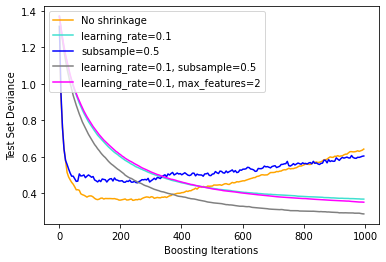

In [36]:
plt.figure()

for label, color, setting in [('No shrinkage', 'orange',
                               {'learning_rate': 1.0, 'subsample': 1.0}),
                              ('learning_rate=0.1', 'turquoise',
                               {'learning_rate': 0.1, 'subsample': 1.0}),
                              ('subsample=0.5', 'blue',
                               {'learning_rate': 1.0, 'subsample': 0.5}),
                              ('learning_rate=0.1, subsample=0.5', 'gray',
                               {'learning_rate': 0.1, 'subsample': 0.5}),
                              ('learning_rate=0.1, max_features=2', 'magenta',
                               {'learning_rate': 0.1, 'max_features': 2})]:
    params = dict(original_params)
    params.update(setting)

    clf = ensemble.GradientBoostingClassifier(**params)
    clf.fit(X_train, y_train)

    # compute test set deviance
    test_deviance = np.zeros((params['n_estimators'],), dtype=np.float64)

    for i, y_pred in enumerate(clf.staged_decision_function(X_test)):
        # clf.loss_ assumes that y_test[i] in {0, 1}
        test_deviance[i] = clf.loss_(y_test, y_pred)

    plt.plot((np.arange(test_deviance.shape[0]) + 1)[::5], test_deviance[::5],
            '-', color=color, label=label)

plt.legend(loc='upper left')
plt.xlabel('Boosting Iterations')
plt.ylabel('Test Set Deviance')

plt.show()

## Histogram-Based Gradient Boosting: [Classification](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html#sklearn.ensemble.HistGradientBoostingClassifier) and [Regression](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html#sklearn.ensemble.HistGradientBoostingRegressor)
- New in Scikit 0.21, inspired by [LightGBM](https://github.com/Microsoft/LightGBM)
- Can be *orders of magnitude faster* than Gradient Boosting
- Built-in support for missing values (NaNs)
- Bins input samples into integer-valued bins (typically 256), which reduces the number of splitting point decision & leverages integer-based data structures.
- Still experimental!

In [37]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.datasets import make_hastie_10_2

X, y = make_hastie_10_2(random_state=0)
X_train, X_test = X[:2000], X[2000:]
y_train, y_test = y[:2000], y[2000:]

clf = HistGradientBoostingClassifier(max_iter=100).fit(X_train, y_train)
clf.score(X_test, y_test)

0.8965

- early stopping enabled by default if number of samples > 10000
- NaNs handled during training by deciding whether missing values should go to left or right child node, based on potential gain.

In [38]:
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingClassifier
import numpy as np

X = np.array([0, 1, 2, np.nan]).reshape(-1, 1)
y = [0, 0, 1, 1]

gbdt = HistGradientBoostingClassifier(min_samples_leaf=1).fit(X, y)
gbdt.predict(X)

array([0, 0, 1, 1])

- When the "missingness" pattern is predictive, the splits can be handled via whether the feature value is missing. 

In [39]:
X = np.array([0, np.nan, 1, 2, np.nan]).reshape(-1, 1)
y = [0, 1, 0, 0, 1]
gbdt = HistGradientBoostingClassifier(min_samples_leaf=1,
                                      max_depth=2,
                                      learning_rate=1,
                                      max_iter=1).fit(X, y)
gbdt.predict(X)

array([0, 1, 0, 0, 1])

- sample weight support

In [40]:
X = [[1, 0],
     [1, 0],
     [1, 0],
     [0, 1]]
y = [0, 0, 1, 0]
# ignore the first 2 training samples by setting their weight to 0
sample_weight = [0, 0, 1, 1]
gb = HistGradientBoostingClassifier(min_samples_leaf=1)
gb.fit(X, y, sample_weight=sample_weight)

gb.predict([[1, 0]])

gb.predict_proba([[1, 0]])[0, 1]

0.9990209190235209